In [40]:
import mne
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [44]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.datasets import sample
from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler, \
                         Vectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedShuffleSplit, \
                                    RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [45]:
SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
filename_epoch = SAVE_EPOCH_ROOT +  'epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif'

#Read Epochs
epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True, verbose=None)
epochs = epochs_orig.copy()
subset = epochs['pred']['non'].copy()
subset = subset.pick_types(eeg=True)
subset.crop(tmin=-0.45,tmax=0.45)

Reading ../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<ipython-input-45-5428fbcee6a7>:9: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset.crop(tmin=-0.45,tmax=0.45)


<EpochsFIF  |   876 events (all good), -0.4 - 0.448 sec, baseline [-0.4, 0], ~183.9 MB, data loaded, with metadata,
 'pred/down/non': 216
 'pred/left/non': 224
 'pred/right/non': 219
 'pred/up/non': 217>

In [46]:
class arguments:
    def __init__(self, cond_block, cond_decoding, applyBaseline_bool, n_splits):
        self.cond_block = cond_block #'later' #{early,later}
        self.cond_decoding = cond_decoding #'removeevoked' #{none,removeevoked,resampled}
        self.applyBaseline_bool = applyBaseline_bool #'False'
        self.n_splits = n_splits#100

        self.SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
        self.SAVE_RESULT_ROOT = '../../results/autocorr/blanca/'
        self.cond_filter ='none' # {none,non_symm}
        self.cond_time = 'prestim' #{prestim,poststim}
        self.subj_num = 1
        self.pre_tmin = -0.4
        self.pre_tmax = 0.05
        self.post_tmin = 0.05
        self.post_tmax = 0.45
        self.num_classes = 2
        self.normalization_type = 'normal'# {normal,lstmPaper}
        self.gen_rand_perm = 0
        self.null_max_iter = 10000
        self.loop_null_iter = 5
        self.gen_decoder_scores = 1
        self.random_state = 42 
        self.max_iter = 10000
        self.n_jobs = 1
        self.scoring = 'roc_auc'
        self.folder='noneFilter_PrePost_decod%s_bsline%s%s/' %(cond_decoding, \
                                                       applyBaseline_bool, \
                                                       n_splits)
        self.SAVE_RESULT_ROOT = self.SAVE_RESULT_ROOT + self.folder
        print(self.SAVE_RESULT_ROOT)



# load nested list results using pickle

In [47]:
selected_subj_P1 = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15, 16, \
                    42, 43, 44, 45, 47, 48, 51, 52, 53, \
                    55, 56, 57, 58, 59, 60, 61, 62, 63, 64, \
                    66, 67, 68, 69, 71, 72, 73, 74]
selected_subj_P2 = [18, 19, 20, 21, 23, 24, 26, 28, 29, 30, \
                   31, 32, 33, 34, 35, 36, 38, 39]

In [48]:
# args = arguments('early', 'none', 'False', '_3k' )
# avgp1_aucrr=[]

# main_ptrn = 1
# args.subj_num = 1

# fn_str_sbj='autocorr_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_Subj_%s' \
#         %(args.cond_block, args.cond_filter, \
#         args.cond_decoding, args.applyBaseline_bool, \
#         args.n_splits, args.subj_num)

# fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj


# with open(fn_str, 'rb') as f:
#     sc_subj_pck = pickle.load(f)

# print(sc_subj_pck.shape)
# avgp1_aucrr.append(sc_subj_pck)


In [49]:
def combine_subj_scores(args, subj_p1, subj_p2):

    avgp1_autcrr=[]
    avgp2_autcrr=[]

    for subj_id in selected_subj_P1:
        main_ptrn = 1
        args.subj_num = subj_id

        fn_str_sbj='autocorr_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits, args.subj_num)

        fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj


        with open(fn_str, 'rb') as f:
            autcrr = pickle.load(f)

        avgp1_autcrr.append(autcrr)


    for subj_id in selected_subj_P2:
        main_ptrn = 2
        args.subj_num = subj_id

        fn_str_sbj='autocorr_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits, args.subj_num)

        fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj


        with open(fn_str, 'rb') as f:
            autcrr = pickle.load(f)


        avgp2_autcrr.append(autcrr)
        


    print('p1 subjects:',np.asarray(avgp1_autcrr).shape)
    print('p2 subjects', np.asarray(avgp2_autcrr).shape)

    p1=np.asarray(avgp1_autcrr)
    p2=np.asarray(avgp2_autcrr)
    p=np.concatenate((p1, p2), axis=0)

    return p

# Autocorrelation

In [67]:
def plot_autocorr(title, avgmap_e, avgmap_l, avgmap_d, vmin, vmax):

    fig, ax = plt.subplots(1, 1)
    plt.tight_layout()
    im = ax.imshow(avgmap_e, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('earlyBlocks - ' + title)
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    # plt.tight_layout()

    # -----------#
    fig, ax = plt.subplots(1, 1)
    plt.tight_layout()
    im = ax.imshow(avgmap_l, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('laterBlocks - ' + title)
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    # plt.tight_layout()

    # -----------#
    fig, ax = plt.subplots(1, 1)
    plt.tight_layout()
    im = ax.imshow(avgmap_d, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('diff(late-early) - ' + title)
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()


    plt.show()

# Different conditions

### Four conds
1. noneFilter_PrePost_decodnone_bslineFalse_3k
2. noneFilter_PrePost_decodnone_bslineTrue_3k
3. noneFilter_PrePost_decodremoveevoked_bslineFalse
4. noneFilter_PrePost_decodremoveevoked_bslineTrue


## cond1
1. noneFilter_PrePost_decodnone_bslineFalse_3k

../../results/autocorr/blanca/noneFilter_PrePost_decodnone_bslineFalse_3k/
p1 subjects: (39, 213, 213)
p2 subjects (18, 213, 213)
p early all subjects: (57, 213, 213)
../../results/autocorr/blanca/noneFilter_PrePost_decodnone_bslineFalse_3k/
p1 subjects: (39, 213, 213)
p2 subjects (18, 213, 213)
p later all subjects: (57, 213, 213)
p diff all subjects: (57, 213, 213)


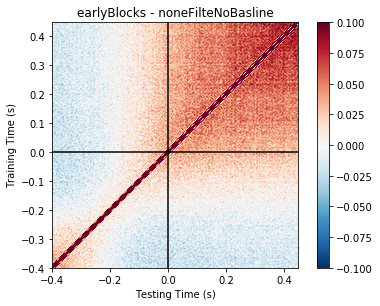

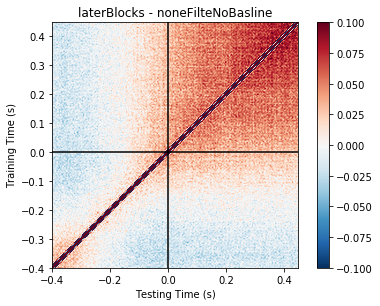

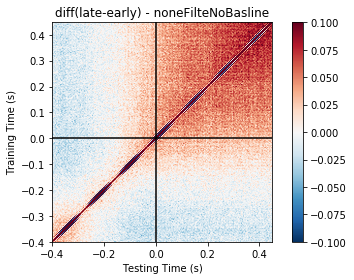

In [68]:
# early ------------- #
args = arguments('early', 'none', 'False', '_3k' )
map_e = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
print('p early all subjects:',map_e.shape)
# map_e = np.mean(map_e, axis=0)

# late ------------- #
args = arguments('later', 'none', 'False', '_3k' )
map_l = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
print('p later all subjects:',map_l.shape)

# diff ------------- #
map_d = map_l - map_e
print('p diff all subjects:',map_d.shape)

avgmap_e = np.mean(map_e, axis=0)
avgmap_l = np.mean(map_l, axis=0)
avgmap_d = np.mean(map_d, axis=0)

#  plot ------------- #
vmin=-0.1
vmax=0.1
title='noneFilteNoBasline'
plot_autocorr(title, avgmap_e, avgmap_l, avgmap_l, vmin, vmax)

## cond2
2. noneFilter_PrePost_decodnone_bslineTrue_3k

../../results/autocorr/blanca/noneFilter_PrePost_decodnone_bslineTrue_3k/
p1 subjects: (39, 213, 213)
p2 subjects (18, 213, 213)
p early all subjects: (57, 213, 213)
../../results/autocorr/blanca/noneFilter_PrePost_decodnone_bslineTrue_3k/
p1 subjects: (39, 213, 213)
p2 subjects (18, 213, 213)
p later all subjects: (57, 213, 213)
p diff all subjects: (57, 213, 213)


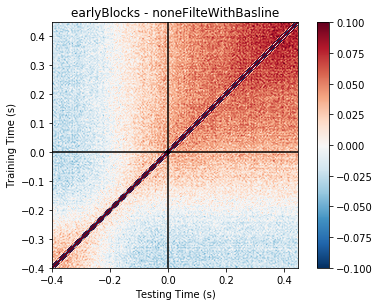

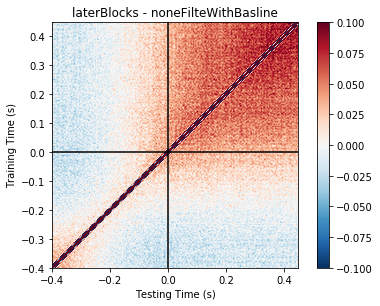

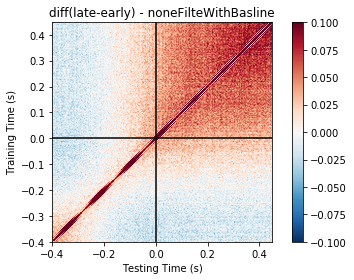

In [70]:
# early ------------- #
args = arguments('early', 'none', 'True', '_3k' )
map_e = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
print('p early all subjects:',map_e.shape)
# map_e = np.mean(map_e, axis=0)

# late ------------- #
args = arguments('later', 'none', 'True', '_3k' )
map_l = combine_subj_scores(args, selected_subj_P1, selected_subj_P2)
print('p later all subjects:',map_l.shape)

# diff ------------- #
map_d = map_l - map_e
print('p diff all subjects:',map_d.shape)

avgmap_e = np.mean(map_e, axis=0)
avgmap_l = np.mean(map_l, axis=0)
avgmap_d = np.mean(map_d, axis=0)

#  plot ------------- #
vmin=-0.1
vmax=0.1
title='noneFilteWithBasline'
plot_autocorr(title, avgmap_e, avgmap_l, avgmap_l, vmin, vmax)